# Classification using Transfer Learning 


Welcome to the final assignment, where you'll be using transfer learning on a pre-trained CNN to build a classifier!

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

By the end of this assignment, you will be able to:

- Create a dataset from a directory
- Preprocess and augment data using the Sequential API
- Adapt a pretrained model to new data and train a classifier using the Functional API and MobileNet
- Fine-tune a classifier's final layers to improve accuracy

<a name='1'></a>
## 1 - Import Packages

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

<a name='1-1'></a>
### 1.1 Create the Dataset and Split it into Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

If you're specifying a validation split, you'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

You'll also set your seeds to match each other, so your training and validation sets don't overlap. :) 

#### **1- Get the dataset from kaggle: https://www.kaggle.com/datasets/sid4sal/alpaca-dataset-small** 
login to kaggle and download the dataset locally
 
####**2- Extract the data locally and put it in the same folder with this notebook**


In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
import os
!mkdir "/content/drive/MyDrive/Kaggle"


mkdir: cannot create directory ‘/content/drive/MyDrive/Kaggle’: File exists


In [104]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [105]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [106]:
!kaggle datasets download -d sid4sal/alpaca-dataset-small --force --unzip 

 93% 108M/116M [00:02<00:00, 69.5MB/s] 
100% 116M/116M [00:02<00:00, 47.0MB/s]


In [107]:
directory = "/content/drive/MyDrive/Kaggle"

In [108]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Now let's take a look at some of the images from the training set: 

**Note:** The original dataset has some mislabelled images in it as well.

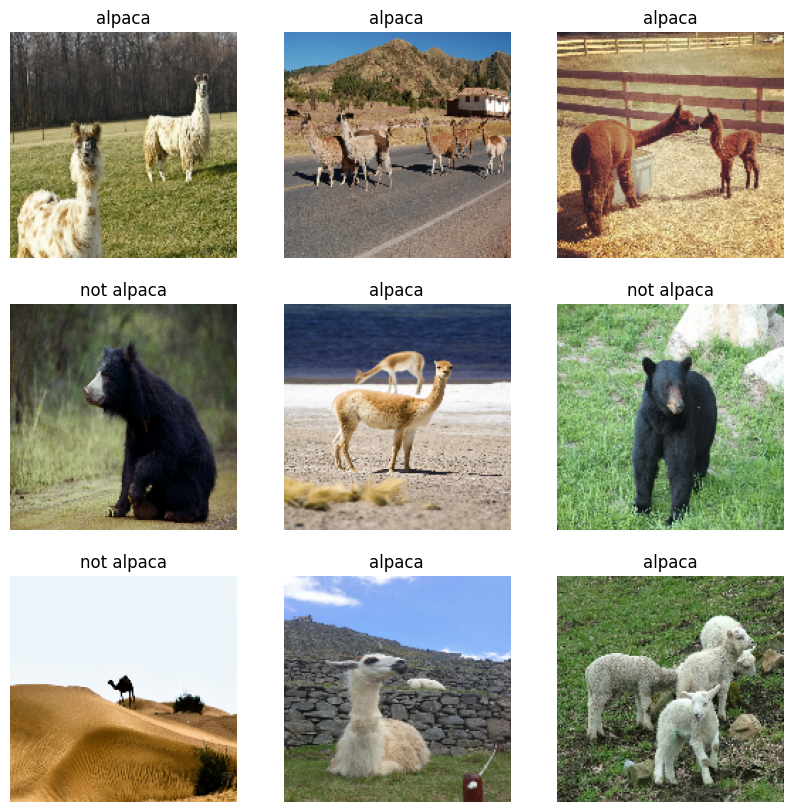

In [109]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.  Ahh, so convenient! 

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [110]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='ex-1'></a>
### Exercise 1 - data augmentation

Implement a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [111]:
def data_augmenter_method():
    from tensorflow.keras import layers
    '''
    Create a Sequential model composed of 2 layers: 
    RandomFlip('horizontal')
    RandomRotation(0.2)
    Returns:
        tf.keras.Sequential model
    '''
    ### START CODE HERE
    seq_data_augmentation = tf.keras.Sequential()
    seq_data_augmentation.add(layers.RandomFlip("horizontal"))
    seq_data_augmentation.add(layers.RandomRotation(0.2))
    ### END CODE HERE
    
    return seq_data_augmentation

Take a look at how an image from the training set has been augmented with simple transformations:

From one animal, to 9 variations of that  animal, in three lines of code. Now your model has a lot more to learn from.

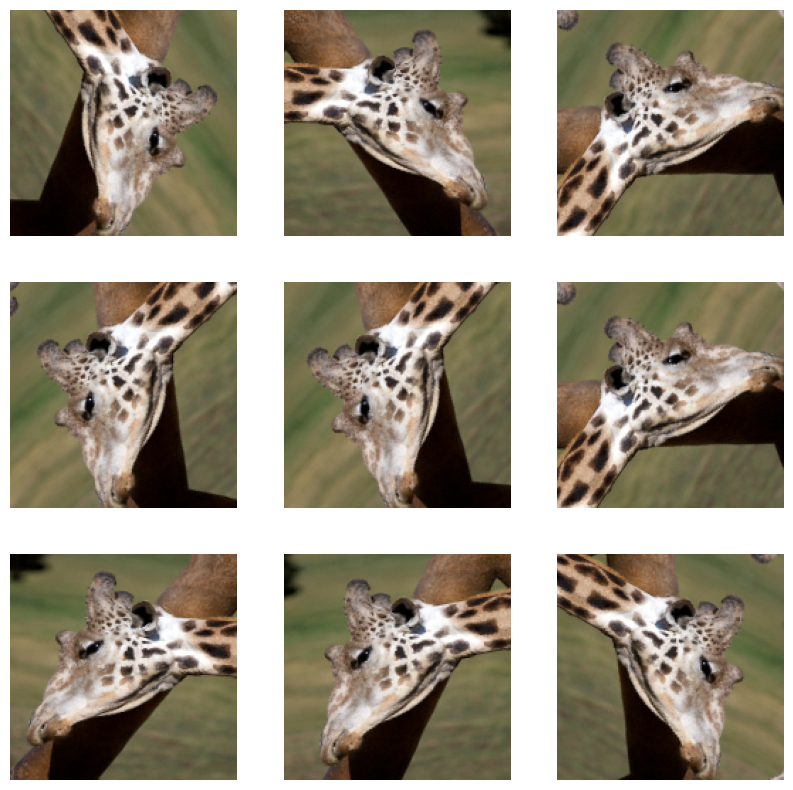

In [112]:
data_augmentation = data_augmenter_method()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

<font color = 'blue'>

**What you should remember:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [113]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Use MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one.


Let's try to train your base model using all the layers from the pretrained model. 

Similarly to how you reused the pretrained normalization values MobileNetV2 was trained on, you'll also load the pretrained weights from ImageNet by specifying `weights='imagenet'`. 

In [114]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

Print the model summary below to see all the model's layers, the shapes of their outputs, and the total number of parameters, trainable and non-trainable. 

In [115]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_13[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [116]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_5
predictions


Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

In [117]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [118]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

Now decode the predictions made by the model. Earlier, when you printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [119]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n02489166', 'proboscis_monkey', 0.103300065),
  ('n02102177', 'Welsh_springer_spaniel', 0.078835875)],
 [('n02125311', 'cougar', 0.16546737), ('n02389026', 'sorrel', 0.107642874)],
 [('n02437312', 'Arabian_camel', 0.29232737),
  ('n02437616', 'llama', 0.2771354)],
 [('n03944341', 'pinwheel', 0.3115499), ('n03047690', 'clog', 0.052499894)],
 [('n02454379', 'armadillo', 0.73107177),
  ('n01990800', 'isopod', 0.038719825)],
 [('n02437312', 'Arabian_camel', 0.2566366),
  ('n02422106', 'hartebeest', 0.121227294)],
 [('n02437616', 'llama', 0.6612556),
  ('n02090721', 'Irish_wolfhound', 0.2378285)],
 [('n02133161', 'American_black_bear', 0.8273565),
  ('n02134418', 'sloth_bear', 0.029259413)],
 [('n01518878', 'ostrich', 0.9267559),
  ('n02002724', 'black_stork', 0.0017766344)],
 [('n01518878', 'ostrich', 0.9495458), ('n02018795', 'bustard', 0.002866155)],
 [('n02437616', 'llama', 0.86998236), ('n02412080', 'ram', 0.0767577)],
 [('n02415577', 'bighorn', 0.24294604), ('n02412080', 'ram', 0.

<a name='3-2'></a>
### 3.2 - Layer Freezing with the Functional API

In the next sections, you'll see how you can use a pretrained model to modify the classifier task so that it's able to recognize animals. You can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

<a name='ex-2'></a>
### Exercise 2 

In [120]:
def second_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter_method()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top= False, 
                                                   weights="imagenet") # ADD CODE HERE INSTEAD OF NONE "use imageNet weights"
    
    # freeze the base model by making it non trainable. ### SET TO FALSE
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=(160, 160, 3)) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) #inputs
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 

    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs =  tf.keras.layers.Dense(1)(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

Create your new model using the data_augmentation function defined earlier.

In [121]:
model2 = second_model(IMG_SIZE, data_augmentation)

In [122]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

The base learning rate has been set for you, so you can go ahead and compile the new model and run it for 5 epochs:

In [123]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [124]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 18s 1s/step - loss: 0.7450 - accuracy: 0.5420 - val_loss: 0.5620 - val_accuracy: 0.6308
Epoch 2/5
9/9 [==============================] - 12s 937ms/step - loss: 0.6000 - accuracy: 0.6107 - val_loss: 0.4462 - val_accuracy: 0.7231
Epoch 3/5
9/9 [==============================] - 11s 1s/step - loss: 0.4839 - accuracy: 0.7328 - val_loss: 0.3807 - val_accuracy: 0.8000
Epoch 4/5
9/9 [==============================] - 10s 907ms/step - loss: 0.4068 - accuracy: 0.7748 - val_loss: 0.3786 - val_accuracy: 0.7077
Epoch 5/5
9/9 [==============================] - 11s 693ms/step - loss: 0.4183 - accuracy: 0.7672 - val_loss: 0.3032 - val_accuracy: 0.8462


Plot the training and validation accuracy:

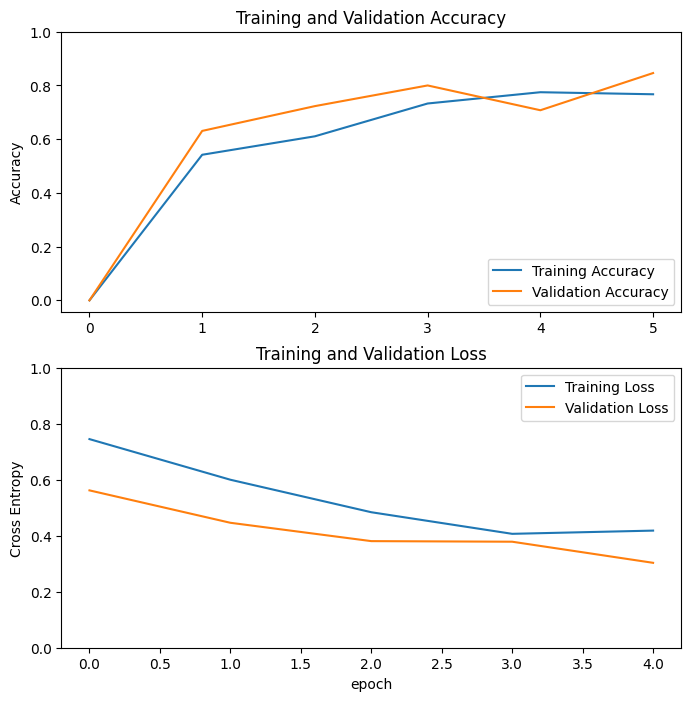

In [125]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [126]:
class_names

['alpaca', 'not alpaca']

The results are ok, but could be better. Next, try some fine-tuning.

<a name='3-3'></a>
### 3.3 - Fine-tuning the Model

You could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth. 

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved!

<a name='ex-3'></a>
### Exercise 3

In [127]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits = True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
base_learning_rate = 4
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001*base_learning_rate)

# Use accuracy as evaluation metric
metrics= ["accuracy"]

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [128]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 21s 1s/step - loss: 7.0004 - accuracy: 0.5229 - val_loss: 1.0864 - val_accuracy: 0.6154
Epoch 6/10
9/9 [==============================] - 13s 1s/step - loss: 1.2619 - accuracy: 0.5038 - val_loss: 0.6688 - val_accuracy: 0.3846
Epoch 7/10
9/9 [==============================] - 12s 1s/step - loss: 0.9835 - accuracy: 0.4695 - val_loss: 0.6717 - val_accuracy: 0.3846
Epoch 8/10
9/9 [==============================] - 13s 1s/step - loss: 0.9383 - accuracy: 0.5153 - val_loss: 0.6737 - val_accuracy: 0.3846
Epoch 9/10
9/9 [==============================] - 13s 1s/step - loss: 0.9096 - accuracy: 0.4885 - val_loss: 0.7915 - val_accuracy: 0.6154
Epoch 10/10
9/9 [==============================] - 11s 1s/step - loss: 1.1220 - accuracy: 0.4771 - val_loss: 0.6678 - val_accuracy: 0.3846


Ahhh, quite an improvement! A little fine-tuning can really go a long way.

In [129]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

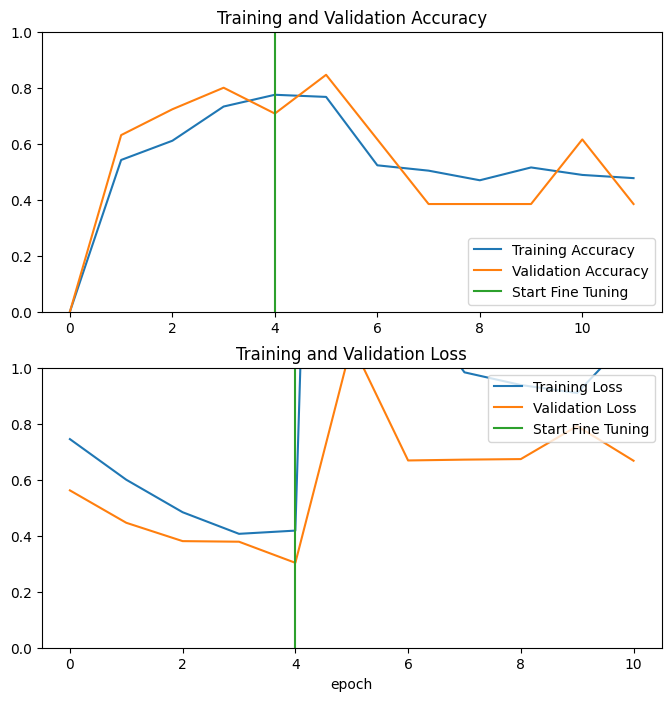

In [130]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [133]:
def download_history():
  import pickle
  from google.colab import files

  with open('model2_fineTex3.pkl', 'wb') as f:
    pickle.dump(model2.history, f)

  files.download('model2_fineTex3.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>